In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.2.4
!pip install keras_tqdm

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as A
# https://www.youtube.com/watch?v=n_f6d4bPFME <- albumentations 강의
# numpy, OpenCV, 여러 라이브러리 기반, 속도 빠름

# https://github.com/qubvel/segmentation_models <- 모델 학습 링크

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/My Drive/FPN/libs')
print(sys.path)
import segmentation_models as sm

Using TensorFlow backend.


2.2.4
1.15.0
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/FPN/libs']
Segmentation Models: using `keras` framework.


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
#from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam


# Set some parameters # 3/23 : 256,512 -> (690,1600)(X) , (688,1600)(O), (512,1024)
IMG_WIDTH = 768
IMG_HEIGHT = 1536
IMG_CHANNELS = 3

# 파일 경로 설정
npy_path = '/content/drive/My Drive/FPN/1536_768/'


x_train_load = np.load(npy_path+'x_train.npy')
y_train_load = np.load(npy_path+'y_train.npy') # dim : 4

x_val_load = np.load(npy_path+'x_val.npy')
y_val_load = np.load(npy_path+'y_val.npy') # dim :4


TEST_PATH = '/content/drive/My Drive/FPN/test_imgs/'
TEST_PATH_IMG=TEST_PATH # 예측할 데이터 파일

test_ids_img = next(os.walk(TEST_PATH_IMG))[2] 
test_ids_img.sort()

In [ ]:
print(x_train_load.dtype)
print(y_train_load.dtype)
print(x_val_load.dtype)
print(x_val_load.dtype)


uint8
uint8
uint8
uint8


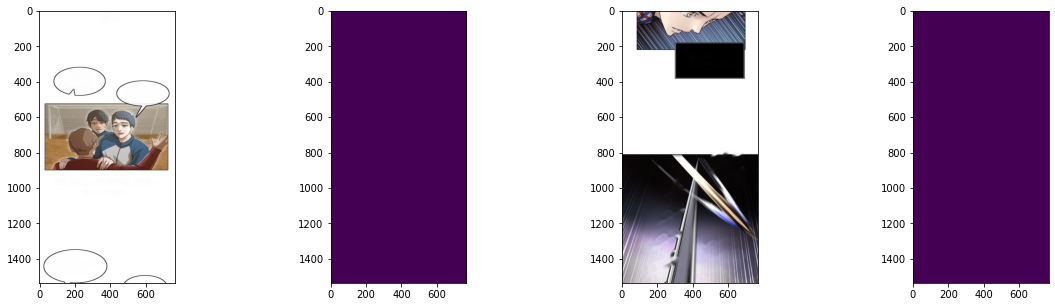

In [ ]:
import random
import matplotlib.pyplot as plt

ix = random.randint(0, len(x_val_load))
tx = random.randint(0, len(y_val_load))

_,axes = plt.subplots(1,4, figsize=(20,5))

axes[0].imshow(x_train_load[ix])
axes[1].imshow(np.squeeze(y_train_load[ix]))
axes[2].imshow(x_val_load[tx])
axes[3].imshow(np.squeeze(y_val_load[tx]))
plt.show()

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
# classes for data loading and preprocessing
class Dataset:        
    def __init__(
            self, 
            images_path, 
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_path = images_path
        self.masks_path = masks_path
        
        # convert str names to class values on masks
        self.class_values = [1]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        x = np.copy(self.images_path[i])
        y = np.copy(self.masks_path[i])
        image = x
        mask = y
        mask[mask<128] = 0
        mask[mask>127] = 1
        # print('mask', np.unique(mask))
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        # print('mask2', np.unique(mask))

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
        
    def __len__(self):
        return self.images_path.shape[0]
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        #A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #A.RandomCrop(height=320, width=320, always_apply=True),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        )
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(1536, 768)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
BACKBONE = 'efficientnetb3'#'resnet34'
BATCH_SIZE = 1
LR = 0.0001
EPOCHS = 40
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
# model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)
#model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, input_shape=(None,None,3))
model = sm.FPN(BACKBONE, classes=n_classes, activation=activation, input_shape=(None,None,3))

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
print(y_train_load.shape)
y1_train_load = np.squeeze(y_train_load)
print(y1_train_load.shape)
y1_val_load = np.squeeze(y_val_load)
print(y1_val_load.shape)

(839, 1536, 768, 1)
(839, 1536, 768)
(24, 1536, 768)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1536, 768, 3)
[0. 1.]
(1536, 768, 1)


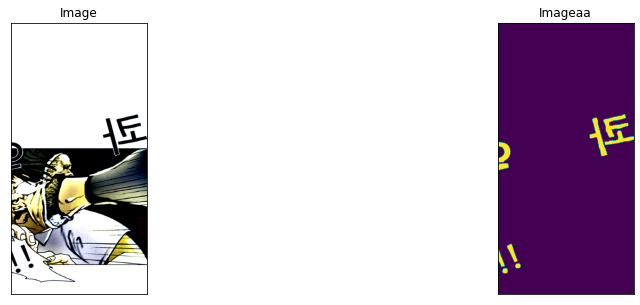

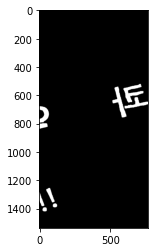

In [ ]:
dataset_train = Dataset(x_train_load, y1_train_load, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocess_input))
dataset_val = Dataset(x_val_load, y1_val_load, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocess_input))
train_dataloader = Dataloder(dataset_train, BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(dataset_val, batch_size=1, shuffle=False)



image, mask = train_dataloader[555] # get some sample
image = image[0]
mask = mask[0]

print(image.shape)
print(np.unique(mask)) 
print(mask.shape)
visualize(
    image=image, 
    imageaa=mask[...,0]
)

plt.imshow(mask[...,0],cmap='gray')
plt.show()

In [ ]:
len(train_dataloader)

839

In [ ]:
!nvidia-smi 

Tue May 19 02:33:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    481MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# 코랩에서 사용 중인 gpu 사용 확인
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

# 코랩에서 gpu를 사용중인지 확인
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#drive_path = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/'
MODEL_SAVE_FOLDER_PATH = '/content/drive/My Drive/FPN/modelcheckpointV2/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH+'{epoch:02d}-{val_loss:.4f}.h5'

In [ ]:
from keras_tqdm import TQDMNotebookCallback
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_loss', 
                               save_best_only=True, save_weights_only= True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    TQDMNotebookCallback()
]

In [ ]:
# 다시 훈련 시킬때 실행 weight파일 이름 넣어야함 
# 예측
#model_path = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/model_checkPoint_test_0502/1536_768_FPN/'
#model.load_weights(model_path+'22-0.4278.h5') #loss 
model.load_weights('/content/drive/My Drive/FPN/iou75modelCheckpointV1/11-0.3676.h5')
# 에포크 7 + 11 + 16 +17
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=700, # (1536,768) -> 1000 터짐 
    epochs=100,
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=50,
    verbose=0
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Epoch 00001: val_loss improved from inf to 0.37237, saving model to /content/drive/My Drive/FPN/modelcheckpointV2/01-0.3724.h5



Epoch 00002: val_loss did not improve from 0.37237



Epoch 00003: val_loss did not improve from 0.37237



Epoch 00004: val_loss did not improve from 0.37237



Epoch 00005: val_loss did not improve from 0.37237



Epoch 00006: val_loss did not improve from 0.37237



Epoch 00007: val_loss did not improve from 0.37237



Epoch 00008: val_loss did not improve from 0.37237



Epoch 00009: val_loss did not improve from 0.37237



Epoch 00010: val_loss did not improve from 0.37237



Epoch 00011: val_loss did not improve from 0.37237



Epoch 00012: val_loss improved from 0.37237 to 0.37145, saving model to /content/drive/My Drive/FPN/modelcheckpointV2/12-0.3714.h5



Epoch 00013: val_loss improved from 0.37145 to 0.37034, saving model to /content/drive/My Drive/FPN/modelcheckpointV2/13-0.3703.h5



Epoch 00014: val_loss did not improve from 0.37034



Epoch 00015: val_loss improved from 0.37034 to 0.36749, saving model to /content/drive/My Drive/FPN/modelcheckpointV2/15-0.3675.h5



Epoch 00016: val_loss did not improve from 0.36749



Epoch 00017: val_loss did not improve from 0.36749


In [ ]:
image.dtype

dtype('float32')

In [ ]:
# 다시 훈련 시킬때 실행 weight파일 이름 넣어야함 
# 예측
#model_path = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/model_checkPoint_test_0502/1536_768_FPN/'
#model.load_weights(model_path+'22-0.4278.h5') #loss 
model.load_weights('/content/drive/My Drive/FPN/modelcheckpointV2/15-0.3675.h5')
# 에포크 

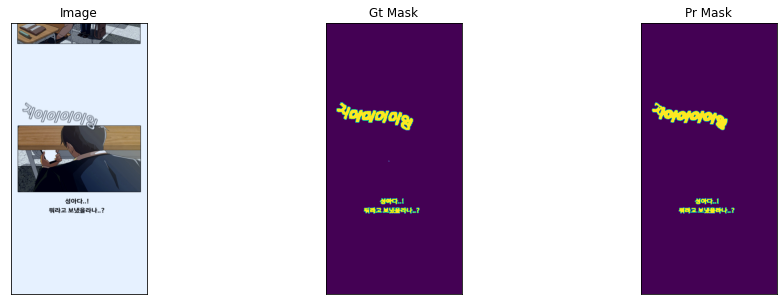

float32
float32
[0. 1.]


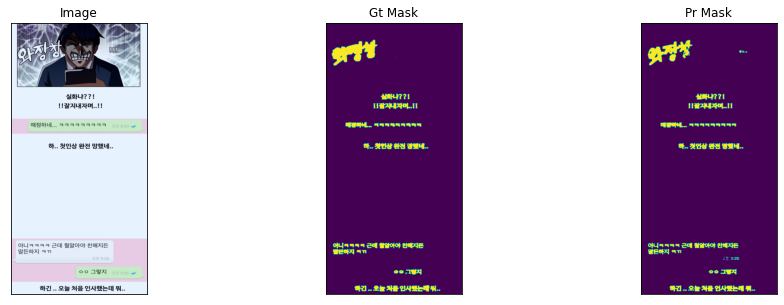

float32
float32
[0. 1.]


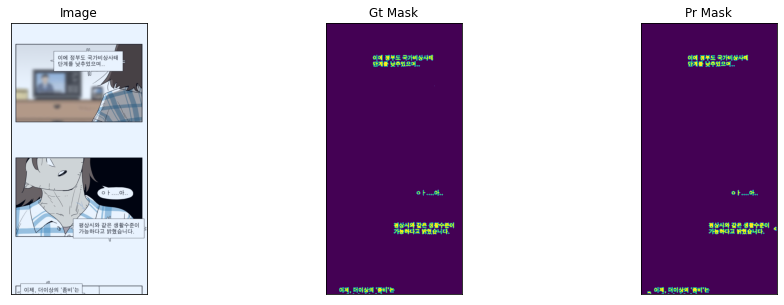

float32
float32
[0. 1.]


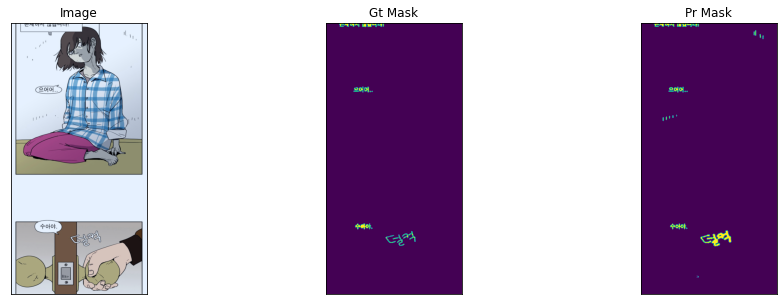

float32
float32
[0. 1.]


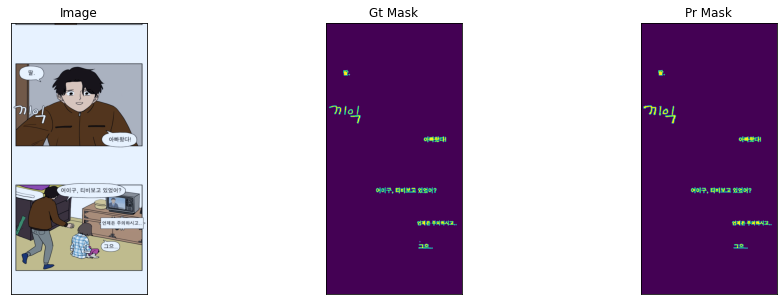

float32
float32
[0. 1.]


In [ ]:
n = 5
# ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in range(5,10):
    image, gt_mask = valid_dataloader[i]
    # image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
    print(image.dtype)
    print(pr_mask.dtype)
    print(np.unique(pr_mask))

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
print(image.dtype)
print(y_train_load.shape)
print(x_train_load.shape)

float32
(839, 1536, 768, 1)
(839, 1536, 768, 3)


In [ ]:

X_test = np.zeros((len(test_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
for n in range(len(test_ids_img)):
    path_img = TEST_PATH_IMG
    img_id_ = test_ids_img[n]
    read_img = cv2.imread((path_img + img_id_),cv2.IMREAD_COLOR)
    read_img = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
    resize_img = cv2.resize(read_img, (IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_AREA)
    X_test[n] = (resize_img)
print(X_test.dtype)
print(X_test.shape)

uint8
(16, 1536, 768, 3)


In [ ]:
#X_test
test_img2 = np.zeros((6, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
for i in range(0,len(test_img2)) :
    test_img2[i] = X_test[i+10]
print(test_img2.dtype)
print(test_img2.shape) 

uint8
(6, 1536, 768, 3)


In [ ]:
########################################
# test_img 전처리
test_img = preprocess_input(test_img2)

In [ ]:
# 주의 : 이미지가 커서 16개이미지로는 GPU리소스 오류남
preds_test = model.predict(test_img, verbose=1)

6/6 [==============================] - 4s 709ms/step


In [ ]:
print(preds_test.shape)
print(preds_test.dtype)

(6, 1536, 768, 1)
float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


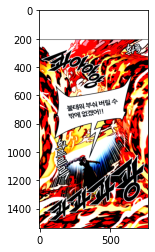

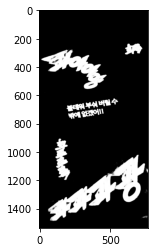

In [ ]:
# Check if training data looks all right
import random
ix = random.randint(0, len(test_img))
plt.imshow(test_img[ix])
plt.show()
plt.imshow(np.squeeze(preds_test[ix]),cmap='gray')
plt.show()

In [ ]:
test_ids_img

In [ ]:

for i in range(len(test_ids_img)) :
    print(test_ids_img[i])

0.png
1.png
10.png
11.png
12.png
13.png
2.png
3.png
306_306.png
307_307.png
308_308.png
309_309.png
4.png
5.png
8.png
9.png


In [ ]:
test_new_ids = [1,2,3,4,5,6]
for i in range(len(test_new_ids)) :
    test_new_ids[i] = test_ids_img[i+10]


In [ ]:
for i in range(len(test_new_ids)) :
    print(test_new_ids[i])

308_308.png
309_309.png
4.png
5.png
8.png
9.png


In [ ]:
# 모델 돌려보기 사진 저장 경로 설정 필요
import cv2  # *255는 위에 mask범위를 보면 0~1인데 마스킹된 부분이 1 -> 노랑으로 되있어서 255를 곱해준다.
path = '/content/drive/My Drive/FPN/predict_img/'
for n, img_name in enumerate(test_new_ids):
    mask_img = np.squeeze(preds_test[n])
    #plt.imsave(path+img_name,(mask_img),cmap='gray')
    cv2.imwrite(path+img_name,(mask_img*255))
print('aa')

aa
